In [1]:
!pip install rdkit

In [2]:
!pip install rdkit-pypi
!pip install matplotlib

In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [5]:
!pip install torchvision

In [6]:
!pip install pytorch-lightning

In [7]:
!pip install deepchem

In [8]:
!pip install pytorch-lightning

In [9]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
import torch
from torch_geometric.data import Data


In [10]:
import os
import csv
import glob
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data

In [11]:
from typing import List, Tuple
import numpy as np

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer
from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot

In [12]:
# from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
# from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
# from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]

USER_ATOM_TYPE_SET  = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
       'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
       'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
       'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb']
USER_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
USER_HYBRIDIZATION_SET = ["SP", "SP2", "SP3", 'SP3D','SP3D2']

In [15]:
def one_hot_encode(value, allowed_values, include_unknown_set=False):
    """Create a one-hot encoded vector based on allowed values."""
    if include_unknown_set and value not in allowed_values:
        value = allowed_values[-1]

    return [1.0 if v == value else 0.0 for v in allowed_values]


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
from torch_geometric.data import Data

class MolGraphConvFeaturizer:
    def __init__(self, use_edges=True, use_chirality=True, use_partial_charge=True):
        self.use_edges = use_edges
        self.use_chirality = use_chirality
        self.use_partial_charge = use_partial_charge

    def featurize(self, smiles):
        # Convert SMILES to RDKit Mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Compute Gasteiger charges if necessary
        if self.use_partial_charge:
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                return None  # Unable to compute charges for this molecule

        # Get atom features
        atom_features = np.array([self._get_atom_features(atom) for atom in mol.GetAtoms()])

        # Get bond features and indices
        if self.use_edges:
            edge_indices, edge_features = self._get_bond_features(mol)
        else:
            edge_indices, edge_features = None, None

        # Create a graph data object
        graph = Data(x=torch.tensor(atom_features, dtype=torch.float),
                     edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices is not None else None,
                     edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)

        return graph

    def _get_atom_features(self, atom):
        # One-hot encoding of atom type
        atom_type = one_hot_encode(atom.GetSymbol(), USER_ATOM_TYPE_SET, include_unknown_set=True)

        # Formal charge of the atom
        formal_charge = get_atom_formal_charge(atom)

        # One-hot encoding of the atom's hybridization
        hybridization = get_atom_hybridization_one_hot(atom, USER_HYBRIDIZATION_SET, include_unknown_set=True)

        # Aromaticity of the atom
        aromatic = get_atom_is_in_aromatic_one_hot(atom)

        # One-hot encoding of the atom's degree
        degree = get_atom_total_degree_one_hot(atom, USER_TOTAL_DEGREE_SET, include_unknown_set=True)

        # One-hot encoding of the total number of hydrogens connected to the atom
        total_num_Hs = get_atom_total_num_Hs_one_hot(atom, DEFAULT_TOTAL_NUM_Hs_SET, include_unknown_set=True)

        # Concatenating all the features
        atom_feat = np.concatenate([
            atom_type, formal_charge, hybridization, aromatic, degree, total_num_Hs
        ])

        if self.use_chirality:
            chirality = get_atom_chirality_one_hot(atom)
            atom_feat = np.concatenate([atom_feat, chirality])

        if self.use_partial_charge:
            partial_charge = get_atom_partial_charge(atom)
            atom_feat = np.concatenate([atom_feat, partial_charge])

        return atom_feat

    def _get_bond_features(self, mol):
        # Initialize lists for source and destination atoms of each bond
        src, dest, bond_features = [], [], []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            src += [start, end]
            dest += [end, start]

            # Extract bond features and duplicate for both bond directions
            bond_feat = self._extract_bond_features(bond)
            bond_features += [bond_feat, bond_feat]

        edge_indices = [src, dest]
        #print("edge_indices : ",edge_indices)
        #print("bond_features : ",bond_features)
        return edge_indices, bond_features
        
    def _extract_bond_features(self, bond):
        """
        Extract bond features from a RDKit bond object.
        """

        # One-hot encoding of bond type
        bond_type = one_hot_encode(bond.GetBondTypeAsDouble(), [1.0, 1.5, 2.0, 3.0], include_unknown_set=True)

        # Whether the bond is in the same ring
        same_ring = [1.0] if bond.IsInRing() else [0.0]

        # Whether the bond is conjugated
        conjugated = [1.0] if bond.GetIsConjugated() else [0.0]

        # One-hot encoding of bond stereo configuration
        stereo = one_hot_encode(bond.GetStereo(), [Chem.rdchem.BondStereo.STEREONONE, 
                                                   Chem.rdchem.BondStereo.STEREOANY, 
                                                   Chem.rdchem.BondStereo.STEREOZ, 
                                                   Chem.rdchem.BondStereo.STEREOE], 
                                include_unknown_set=True)

        # Concatenate all bond features
        bond_feat = np.concatenate([bond_type, same_ring, conjugated, stereo])

        return bond_feat        


In [17]:
# Example usage
#featurizer = MolGraphConvFeaturizer()
#graph = featurizer.featurize('CCO')  # Example SMILES string
#print(type(graph))
#print((graph))

In [18]:
## Assuming graphs[0] is a torch_geometric.data.Data object from your graphs list

## Print node features
#print("Len of graph:", len(graph))
#print("Node Features:")
#for i, node_feature in enumerate(graph.x):
#    print(f"Node {i}: {node_feature}")

## Print edge pairs and edge features
#print("\nEdge Pairs and Features:")
#for i, edge in enumerate(graph.edge_index.t()):
#    src, dest = edge[0].item(), edge[1].item()
#    edge_feature = graph.edge_attr[i]
#    print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


In [19]:
#graph.is_directed()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_graph(data):
    # Create a networkx graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(data.num_nodes):
        G.add_node(i)

    # Add edges to the graph
    edge_index = data.edge_index.t().cpu().numpy()
    for edge in edge_index:
        src, dest = edge[0], edge[1]
        G.add_edge(src, dest)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()
#visualize_graph(graph)

In [21]:
# Load the data 
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-41-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test50k.txt", header=None, names=['SMILES'])


In [22]:
smiles_df.head(5)

,SMILES
0,CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1,CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2,COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3,OCCn1cc(CNc2cccc3c2CCCC3)nn1
4,CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...


In [23]:
# Define a function to convert a SMILES string to a graph data object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    # Get bond features and adjacency information
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [(start, end), (end, start)]
        edge_feature = [bond.GetBondTypeAsDouble()]
        edge_features += [edge_feature, edge_feature]  # add twice for both directions

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create a graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [24]:
def read_smiles_df_check(smiles_df):
    graphs = []
    invalid_indices = []
    for idx, smiles in enumerate(smiles_df['SMILES']):
        graph = smiles_to_graph(smiles)
        if graph:
            graphs.append(graph)
        else:
            print("Invalid graph :", idx,smiles)
            invalid_indices.append(idx)
    return graphs, invalid_indices

graphs, invalid_indices = read_smiles_df_check(smiles_df)
print(f"Number of valid graphs: {len(graphs)}")
print(f"Indices of invalid SMILES: {invalid_indices}")

Number of valid graphs: 41
Indices of invalid SMILES: []


In [25]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 41


In [26]:
# Initialize the featurizer
featurizer = MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)

# Featurize SMILES strings and track invalid entries
graphs = []
invalid_indices = []
for idx, smiles in enumerate(smiles_df['SMILES']):
    print(idx)
    graph = featurizer.featurize(smiles)
    graphs.append(graph)    
    
#    try:
#        graph = featurizer.featurize(smiles)
#        graphs.append(graph)
#    except Exception as e:
#        print(f"Invalid SMILES at index {idx}: {smiles} (Error: {e})")
#        invalid_indices.append(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


C:\Users\Malli\AppData\Local\Temp\ipykernel_17700\3029635957.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)


In [27]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))

Length of smiles_df: 41


In [28]:
print(len(graphs))
print(type(graphs[1]))
print((graphs[1]))

41
<class 'torch_geometric.data.data.Data'>
Data(x=[17, 72], edge_index=[36, 2], edge_attr=[36, 10])


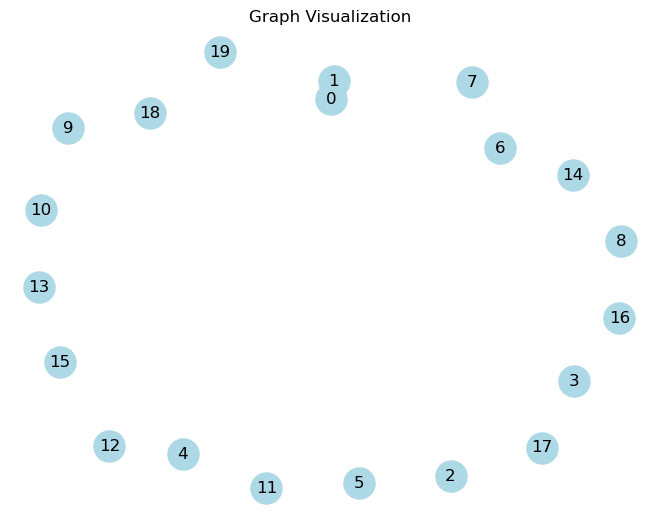

In [29]:
visualize_graph(graphs[3])

In [30]:
!pip install torch_geometric

In [31]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

In [32]:
import torch

# Example graph object from the user's data
graph = graphs[3]

# Extracting edge indices
edge_indices = graph.edge_index.t().tolist()

# Extracting node features (assuming each node has a feature vector)
node_features = graph.x.tolist()

# The nodes can be represented as a list of indices from 0 to the number of nodes - 1
node_indices = list(range(len(node_features)))

# Displaying the node indices and edge indices
#node_indices, edge_indices
#print(node_features)

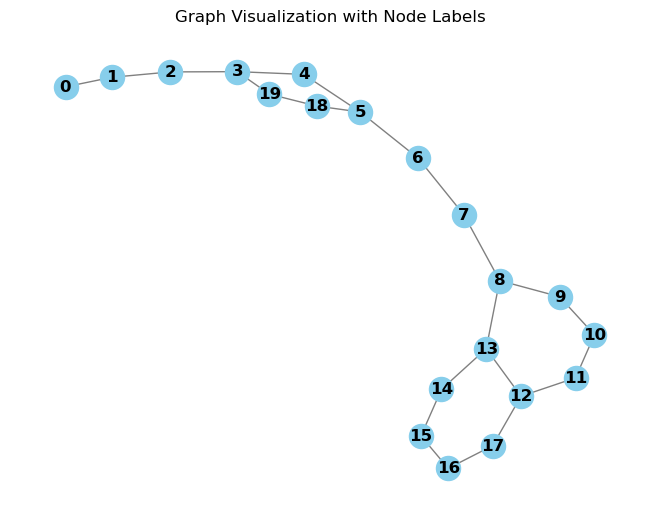

In [33]:
import networkx as nx
import torch_geometric

edge_index = torch.tensor(edge_indices, dtype=torch.long)
x = torch.tensor(node_indices, dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Draw the graph with node labels
pos = nx.spring_layout(g)  # Compute layout
nx.draw(g, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization with Node Labels")
plt.show()

In [34]:
# Print the edge indices
print(graphs[3].edge_index.t().tolist())

[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 5, 18, 18, 19, 19, 3, 13, 8, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 5, 19, 18, 3, 19, 8, 13, 12, 17]]


In [35]:
# graphs[0] is a torch_geometric.data.Data object from your graphs list
graph = graphs[3]

# Print node features
print("Len of graph:", len(graph))
print("Node Features:")
print(len(graph.x))
#for i, node_feature in enumerate(graph.x):
    #print(f"Node {i}: {node_feature}")

# Print edge pairs and edge features
print("\nEdge Pairs and Features:")
print(graph.edge_index.t())
for i, edge in enumerate(graph.edge_index.t()):
    src, dest = edge[0].item(), edge[1].item()
    edge_feature = graph.edge_attr[i]
    #print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


Len of graph: 3
Node Features:
20

Edge Pairs and Features:
tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,  5, 18,
         18, 19, 19,  3, 13,  8, 17, 12],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,  5,
         19, 18,  3, 19,  8, 13, 12, 17]])


In [36]:
# Extracting edge list and edge features from the provided graph
graph = graphs[5]  

# Extracting edge index
edge_index = graph.edge_index.t()

# Preparing the edge list
edge_list = []
for i in range(edge_index.shape[1]):
    edge = edge_index[:, i]
    edge_list.append((edge[0].item(), edge[1].item()))

edge_list


[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (9, 10),
 (10, 9),
 (1, 11),
 (11, 1),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (14, 24),
 (24, 14),
 (24, 25),
 (25, 24),
 (10, 4),
 (4, 10),
 (25, 11),
 (11, 25),
 (23, 15),
 (15, 23),
 (23, 18),
 (18, 23)]

In [37]:
import torch
from torch_geometric.data import Data

# Assuming graph_data is your list of graph objects
# graph_data[0] is the first graph object

# Select the first graph object
first_graph = graphs[3]

# Convert node features to a floating-point type if they aren't already
node_features_float = first_graph.x.float()

# Inspect node features
print("Node features (x) of the first graph:")
print(node_features_float)
print("Shape of node features:", node_features_float.shape)

# Inspect edge features
print("\nEdge features (edge_attr) of the first graph:")
print(first_graph.edge_attr)
print("Shape of edge features:", first_graph.edge_attr.shape)

# Inspect edge index (connectivity)
print("\nEdge index (edge_index) of the first graph:")
print(first_graph.edge_index)
print("Shape of edge index:", first_graph.edge_index.shape)

# Calculate min and max for each node feature of the first graph
min_values, max_values = node_features_float.min(dim=0)[0], node_features_float.max(dim=0)[0]

print("\nMinimum values of node features:", min_values)
print("Maximum values of node features:", max_values)

# Calculate the standard deviation for each node feature
std_deviation = node_features_float.std(dim=0)
print("\nStandard deviation of node features:", std_deviation)


Node features (x) of the first graph:
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000, -0.3944],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0628],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0658],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0275],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1335],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0670]])
Shape of node features: torch.Size([20, 72])

Edge features (edge_attr) of the first graph:
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1.,

In [38]:
smiles_df['SMILES'][3]

'OCCn1cc(CNc2cccc3c2CCCC3)nn1'

In [39]:
mol = Chem.MolFromSmiles(smiles_df['SMILES'][3])
AllChem.ComputeGasteigerCharges(mol)

In [40]:
edge_indices = []
for bond in mol.GetBonds():
    start_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    edge_indices.append((start_idx, end_idx))
    edge_indices.append((end_idx, start_idx))  # Add the reverse direction


In [41]:
edge_indices

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (5, 18),
 (18, 5),
 (18, 19),
 (19, 18),
 (19, 3),
 (3, 19),
 (13, 8),
 (8, 13),
 (17, 12),
 (12, 17)]

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

In [43]:
print((graphs[0]))
print((smiles_df.head(1)))

Data(x=[25, 72], edge_index=[54, 2], edge_attr=[54, 10])
                                   SMILES
0  CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1


In [44]:
print(len(graphs))
print(len(smiles_df))

41
41


In [45]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 41


In [46]:
smiles_df.head(5)

,SMILES
0,CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1,CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2,COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3,OCCn1cc(CNc2cccc3c2CCCC3)nn1
4,CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...


In [47]:
print(type(graphs[3]))

<class 'torch_geometric.data.data.Data'>


In [48]:
# Unsupervised Graph Generative Adversarial Netwrok

In [49]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [50]:
def generate_random_edge_index(num_nodes):
    # Example implementation to generate a random edge_index
    # Here we create a fully connected graph for simplicity
    edge_index = torch.combinations(torch.arange(num_nodes), r=2)
    return torch.cat([edge_index, edge_index.flip([1])], dim=0).t()  # Making it undirected

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data, Batch
from torch_geometric.utils import erdos_renyi_graph

def generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes):
    """
    Generate random noise for a batch of graphs with variable number of nodes and edges,
    but fixed node feature and edge feature dimensions.

    Args:
    - batch_size (int): Number of random graphs to generate.
    - node_feature_dim (int): Number of features for each node.
    - edge_feature_dim (int): Number of features for each edge.
    - max_num_nodes (int): Maximum number of nodes a graph can have.

    Returns:
    - A list of Data objects containing random noise for node and edge features.
    """
    random_graphs = []

    for _ in range(batch_size):
        # Randomly determine the number of nodes for this graph
        num_nodes = torch.randint(low=1, high=max_num_nodes, size=(1,)).item()

        # Generate random node features
        x = torch.randn(num_nodes, node_feature_dim)

        # Generate a random graph structure (edge_index)
        edge_index = erdos_renyi_graph(num_nodes, edge_prob=0.5)  # p is the probability of an edge

        # Generate random edge features (if needed)
        num_edges = edge_index.size(1)
        edge_attr = torch.randn(num_edges, edge_feature_dim) if edge_feature_dim > 0 else None

        # Create a Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        random_graphs.append(data)

    #return random_graphs
    return Batch.from_data_list(random_graphs)





In [52]:
# Example usage
batch_size = 32
node_feature_dim = 72  # Number of node features
edge_feature_dim = 10  # Number of edge features, adjust as needed
max_num_nodes = 50    # Maximum number of nodes in a graph

random_noise_graphs = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)

In [53]:
random_noise_graphs 

DataBatch(x=[815, 72], edge_index=[2, 12740], edge_attr=[12740, 10], batch=[815], ptr=[33])

In [54]:
# Generator Model
class Generator_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index gen",type(x), type(edge_index))
        #print("x, edge_index gen",x.size(), edge_index.size())
        #print("x, edge_index gen",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("Generator x layer 1:",x)
        x = torch.sigmoid(self.layer2(x, edge_index))
        #print("Generator x  layer 2:",x)
        return x

In [55]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.layer1(x, edge_index))
        x = torch.sigmoid(self.layer2(x, edge_index))

        # Generate fake edge_index (simple example, should be improved)
        fake_edge_index = self.generate_fake_edge_index(x.size(0))
        return x, fake_edge_index

    def generate_fake_edge_index(self, num_nodes):
        # Implement logic to generate a plausible edge_index for fake graphs
        # Placeholder logic: create a simple linear chain graph
        edge_index = torch.tensor([[i, i+1] for i in range(num_nodes - 1)], dtype=torch.long).t()
        return edge_index


In [56]:
# Discriminator Model  
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        #print("In discriminator")
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("self.layer1",input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        #print("self.layer2",hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index1",type(x), type(edge_index))
        #print("x, edge_index2",x.size(), edge_index.size())
        #print("x, edge_index3",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("x 2",x)
        x = torch.sigmoid(self.layer2(x))
        #print("x 3",x)
        return x

In [57]:
# Model Initialization
generator_input_dim = 72
generator_hidden_dim = 256
#generator_hidden_dim = 128
generator_output_dim = 72

discriminator_input_dim = 72
discriminator_hidden_dim = 256
#discriminator_hidden_dim = 128

In [58]:
generator = Generator(generator_input_dim, generator_hidden_dim, generator_output_dim)
discriminator = Discriminator(discriminator_input_dim, discriminator_hidden_dim)

In [59]:
import torch.optim as optim
from torch_geometric.data import DataLoader
#from torch_geometric.loader import DataLoader

from torch.utils.data import Dataset

# Sample data loader (replace with your dataset)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=['x', 'edge_index'])
data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=[])



# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function
adversarial_loss = torch.nn.BCELoss()

C:\Users\Malli\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [60]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(discriminator, real_data, fake_data):
    real_predictions = discriminator(real_data).round()
    fake_predictions = discriminator(fake_data).round()
    correct_predictions = (real_predictions == 1).sum() + (fake_predictions == 0).sum()
    total_predictions = real_predictions.numel() + fake_predictions.numel()
    accuracy = 100 * correct_predictions.float() / total_predictions
    return accuracy

In [61]:
print((data_loader))

In [62]:
print((graphs[3].x).shape)
print((graphs[3].edge_index).shape)

torch.Size([20, 72])
torch.Size([44, 2])


In [63]:
print((graphs[0].x).shape)
print((graphs[0].edge_index).shape)

torch.Size([25, 72])
torch.Size([54, 2])


In [64]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

def custom_graph_data_loader(graph_dataset, batch_size):
    """
    Custom data loader for graph data.
    
    Args:
    - graph_dataset (list of Data): The dataset containing graph Data objects.
    - batch_size (int): The size of each batch.

    Yields:
    - Batched Data object containing a batch of graphs.
    """

    def batch_graphs(graphs):
        """
        Manually batches a list of graphs into a single Batch object.
        """
        batched_edge_index = []
        batched_x = []
        batched_batch = []

        current_node_idx = 0
        for i, graph in enumerate(graphs):
            # Offset the node indices by the current_node_idx and add them to the batched edge index.
            #edge_index_offset = graph.edge_index + current_node_idx
            #batched_edge_index.append(edge_index_offset)
            
            # Offset only the node indices in the edge_index tensor.
            edge_index_offset = graph.edge_index.clone()  # Make a copy to avoid modifying the original graph
            edge_index_offset[0, :] += current_node_idx  # Offset source node indices
            edge_index_offset[1, :] += current_node_idx  # Offset target node indices
            #batched_edge_index.append(edge_index_offset)            
            
            #Tring edge_index
            #batched_edge_index.append(graph.edge_index)
            batched_edge_index.append(graph.edge_index + current_node_idx)

            # Add the current graph's node features to the batched node features.
            batched_x.append(graph.x)

            # Add the graph index to the batch vector for all nodes of this graph.
            batched_batch.append(torch.full((graph.x.size(0),), i, dtype=torch.long))

            # Update the current_node_idx for the next graph.
            current_node_idx += graph.x.size(0)

        # Concatenate all the lists to create tensors.       
        
        batched_edge_index = torch.cat(batched_edge_index, dim=0)
        batched_x = torch.cat(batched_x, dim=0)
        batched_batch = torch.cat(batched_batch, dim=0)
        

        # Create a new Data object to hold the batched graph.
        batched_data = Data(x=batched_x, edge_index=batched_edge_index)
        batched_data.batch = batched_batch

        return batched_data

    # Shuffle dataset at the beginning of each epoch
    indices = torch.randperm(len(graph_dataset))
    
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_graphs_list = [graph_dataset[i] for i in batch_indices]
        batch = batch_graphs(batch_graphs_list)
        yield batch


In [65]:
import matplotlib.pyplot as plt
import torch

def calculate_accuracy(preds, labels):
    predicted_labels = preds.round()  # Convert probabilities to 0/1
    correct = (predicted_labels == labels).float()  # Convert into float for division 
    accuracy = correct.sum() / len(correct)
    return accuracy

In [66]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

In [67]:
# Visualization function
def visualize_fake_graph(node_features, edge_index, epoch):
    G = create_networkx_graph(node_features, edge_index)
    # Customize your graph visualization here (e.g., using node/edge frequencies)
    nx.draw(G, with_labels=True)
    plt.savefig(f'graph_snapshot_epoch_{epoch}.png')

# Create a NetworkX graph from node features and edge index
def create_networkx_graph(node_features, edge_index):
    G = nx.Graph()
    for i, feature in enumerate(node_features):
        G.add_node(i, feature=feature)
    for source, target in edge_index.t().numpy():
        G.add_edge(source, target)
    return G

# Function to update frequency counts
def update_frequency_counts(edge_index, edge_freq, node_freq):
    for edge in edge_index.t().numpy():
        edge_freq[tuple(sorted(edge))] += 1  # Use sorted to treat edges as undirected
    for node in edge_index.unique().numpy():
        node_freq[node] += 1

In [68]:
num_epochs = 50
batch_size = 32

# Lists to store metrics
epochs = []
d_losses = []
g_losses = []
real_accuracy_list =[]
fake_accuracy_list=[]
d_accuracies = []

# Dictionary to track edge/node frequency
edge_frequency = defaultdict(int)
node_frequency = defaultdict(int)

# To define how often to take snapshots 
snapshot_interval = 5  

epoch 0
real_accuracy tensor(0.3623)
fake_accuracy tensor(1.)
d_loss.item() 1.353935718536377
g_loss.item() 0.8416520953178406
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 1, (1, 2): 1, (2, 3): 1, (3, 4): 1, (4, 5): 1, (5, 6): 1, (6, 7): 1, (7, 8): 1, (8, 9): 1, (9, 10): 1, (10, 11): 1, (11, 12): 1, (12, 13): 1, (13, 14): 1, (14, 15): 1, (15, 16): 1, (16, 17): 1, (17, 18): 1, (18, 19): 1, (19, 20): 1, (20, 21): 1, (21, 22): 1, (22, 23): 1, (23, 24): 1, (24, 25): 1, (25, 26): 1, (26, 27): 1, (27, 28): 1, (28, 29): 1, (29, 30): 1, (30, 31): 1, (31, 32): 1, (32, 33): 1, (33, 34): 1, (34, 35): 1, (35, 36): 1, (36, 37): 1, (37, 38): 1, (38, 39): 1, (39, 40): 1, (40, 41): 1, (41, 42): 1, (42, 43): 1, (43, 44): 1, (44, 45): 1, (45, 46): 1, (46, 47): 1, (47, 48): 1, (48, 49): 1, (49, 50): 1, (50, 51): 1, (51, 52): 1, (52, 53): 1, (53, 54): 1, (54, 55): 1, (55, 56): 1, (56, 57): 1, (57, 58): 1, (58, 59): 1, (59, 60): 1, (60, 61): 1, (61, 62): 1, (62, 63): 1, (63, 64): 1, (

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 2, (4, 5): 2, (5, 6): 2, (6, 7): 2, (7, 8): 2, (8, 9): 2, (9, 10): 2, (10, 11): 2, (11, 12): 2, (12, 13): 2, (13, 14): 2, (14, 15): 2, (15, 16): 2, (16, 17): 2, (17, 18): 2, (18, 19): 2, (19, 20): 2, (20, 21): 2, (21, 22): 2, (22, 23): 2, (23, 24): 2, (24, 25): 2, (25, 26): 2, (26, 27): 2, (27, 28): 2, (28, 29): 2, (29, 30): 2, (30, 31): 2, (31, 32): 2, (32, 33): 2, (33, 34): 2, (34, 35): 2, (35, 36): 2, (36, 37): 2, (37, 38): 2, (38, 39): 2, (39, 40): 2, (40, 41): 2, (41, 42): 2, (42, 43): 2, (43, 44): 2, (44, 45): 2, (45, 46): 2, (46, 47): 2, (47, 48): 2, (48, 49): 2, (49, 50): 2, (50, 51): 2, (51, 52): 2, (52, 53): 2, (53, 54): 2, (54, 55): 2, (55, 56): 2, (56, 57): 2, (57, 58): 2, (58, 59): 2, (59, 60): 2, (60, 61): 2, (61, 62): 2, (62, 63): 2, (63, 64): 2, (64, 65): 2, (65, 66): 2, (66, 67): 2, (67, 68): 2, (68, 69): 2, (69, 70): 2, (70, 71): 2, (71, 72): 2, (72, 73): 2, (73, 74): 2

real_accuracy tensor(0.9229)
fake_accuracy tensor(1.)
d_loss.item() 0.9890546798706055
g_loss.item() 1.451939582824707
real_accuracy tensor(0.9798)
fake_accuracy tensor(1.)
d_loss.item() 0.9490134716033936
g_loss.item() 1.5510891675949097
epoch 4
real_accuracy tensor(0.9892)
fake_accuracy tensor(1.)
d_loss.item() 0.910524845123291
g_loss.item() 1.6576350927352905
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.8785266876220703
g_loss.item() 1.7586251497268677
epoch 5
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.8459160327911377
g_loss.item() 1.8518651723861694
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 3, (1, 2): 3, (2, 3): 3, (3, 4): 3, (4, 5): 3, (5, 6): 3, (6, 7): 3, (7, 8): 3, (8, 9): 3, (9, 10): 3, (10, 11): 3, (11, 12): 3, (12, 13): 3, (13, 14): 3, (14, 15): 3, (15, 16): 3, (16, 17): 3, (17, 18): 3, (18, 19): 3, (19, 20): 3, (20, 21): 3, (21, 22): 3, (22, 23): 3, (23, 24): 3, (24, 25): 3, (25, 26): 3, (26, 27): 3,

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 4, (1, 2): 4, (2, 3): 4, (3, 4): 4, (4, 5): 4, (5, 6): 4, (6, 7): 4, (7, 8): 4, (8, 9): 4, (9, 10): 4, (10, 11): 4, (11, 12): 4, (12, 13): 4, (13, 14): 4, (14, 15): 4, (15, 16): 4, (16, 17): 4, (17, 18): 4, (18, 19): 4, (19, 20): 4, (20, 21): 4, (21, 22): 4, (22, 23): 4, (23, 24): 4, (24, 25): 4, (25, 26): 4, (26, 27): 4, (27, 28): 4, (28, 29): 4, (29, 30): 4, (30, 31): 4, (31, 32): 4, (32, 33): 4, (33, 34): 4, (34, 35): 4, (35, 36): 4, (36, 37): 4, (37, 38): 4, (38, 39): 4, (39, 40): 4, (40, 41): 4, (41, 42): 4, (42, 43): 4, (43, 44): 4, (44, 45): 4, (45, 46): 4, (46, 47): 4, (47, 48): 4, (48, 49): 4, (49, 50): 4, (50, 51): 4, (51, 52): 4, (52, 53): 4, (53, 54): 4, (54, 55): 4, (55, 56): 4, (56, 57): 4, (57, 58): 4, (58, 59): 4, (59, 60): 4, (60, 61): 4, (61, 62): 4, (62, 63): 4, (63, 64): 4, (64, 65): 4, (65, 66): 4, (66, 67): 4, (67, 68): 4, (68, 69): 4, (69, 70): 4, (70, 71): 4, (71, 72): 4, (72, 73): 4, (73, 74): 4

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.7107830047607422
g_loss.item() 2.2927818298339844
epoch 8
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.6916236877441406
g_loss.item() 2.360585927963257
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.6628710627555847
g_loss.item() 2.4415605068206787
epoch 9
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.6448730826377869
g_loss.item() 2.4897663593292236
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.6305018663406372
g_loss.item() 2.5638740062713623
epoch 10
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.6018818616867065
g_loss.item() 2.6051065921783447
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 5, (1, 2): 5, (2, 3): 5, (3, 4): 5, (4, 5): 5, (5, 6): 5, (6, 7): 5, (7, 8): 5, (8, 9): 5, (9, 10): 5, (10, 11): 5, (11, 12): 5, (12, 13): 5, (13, 14): 5, (14, 15): 5, (15, 16): 5, (16, 17): 5, (17, 18): 5, (18, 1

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 6, (1, 2): 6, (2, 3): 6, (3, 4): 6, (4, 5): 6, (5, 6): 6, (6, 7): 6, (7, 8): 6, (8, 9): 6, (9, 10): 6, (10, 11): 6, (11, 12): 6, (12, 13): 6, (13, 14): 6, (14, 15): 6, (15, 16): 6, (16, 17): 6, (17, 18): 6, (18, 19): 6, (19, 20): 6, (20, 21): 6, (21, 22): 6, (22, 23): 6, (23, 24): 6, (24, 25): 6, (25, 26): 6, (26, 27): 6, (27, 28): 6, (28, 29): 6, (29, 30): 6, (30, 31): 6, (31, 32): 6, (32, 33): 6, (33, 34): 6, (34, 35): 6, (35, 36): 6, (36, 37): 6, (37, 38): 6, (38, 39): 6, (39, 40): 6, (40, 41): 6, (41, 42): 6, (42, 43): 6, (43, 44): 6, (44, 45): 6, (45, 46): 6, (46, 47): 6, (47, 48): 6, (48, 49): 6, (49, 50): 6, (50, 51): 6, (51, 52): 6, (52, 53): 6, (53, 54): 6, (54, 55): 6, (55, 56): 6, (56, 57): 6, (57, 58): 6, (58, 59): 6, (59, 60): 6, (60, 61): 6, (61, 62): 6, (62, 63): 6, (63, 64): 6, (64, 65): 6, (65, 66): 6, (66, 67): 6, (67, 68): 6, (68, 69): 6, (69, 70): 6, (70, 71): 6, (71, 72): 6, (72, 73): 6, (73, 74): 6

fake_accuracy tensor(1.)
d_loss.item() 0.5266051292419434
g_loss.item() 2.7424826622009277
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.5046553611755371
g_loss.item() 2.8282992839813232
epoch 13
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.486402302980423
g_loss.item() 2.819537401199341
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.47737133502960205
g_loss.item() 2.7650253772735596
epoch 14
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.4552482068538666
g_loss.item() 2.8309969902038574
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.4338932931423187
g_loss.item() 2.79162335395813
epoch 15
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.42521607875823975
g_loss.item() 2.8121449947357178
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 7, (1, 2): 7, (2, 3): 7, (3, 4): 7, (4, 5): 7, (5, 6): 7, (6, 7): 7, (7, 8): 7, (8, 9): 7, (9, 10): 7, (10, 11): 7, (11, 

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 8, (1, 2): 8, (2, 3): 8, (3, 4): 8, (4, 5): 8, (5, 6): 8, (6, 7): 8, (7, 8): 8, (8, 9): 8, (9, 10): 8, (10, 11): 8, (11, 12): 8, (12, 13): 8, (13, 14): 8, (14, 15): 8, (15, 16): 8, (16, 17): 8, (17, 18): 8, (18, 19): 8, (19, 20): 8, (20, 21): 8, (21, 22): 8, (22, 23): 8, (23, 24): 8, (24, 25): 8, (25, 26): 8, (26, 27): 8, (27, 28): 8, (28, 29): 8, (29, 30): 8, (30, 31): 8, (31, 32): 8, (32, 33): 8, (33, 34): 8, (34, 35): 8, (35, 36): 8, (36, 37): 8, (37, 38): 8, (38, 39): 8, (39, 40): 8, (40, 41): 8, (41, 42): 8, (42, 43): 8, (43, 44): 8, (44, 45): 8, (45, 46): 8, (46, 47): 8, (47, 48): 8, (48, 49): 8, (49, 50): 8, (50, 51): 8, (51, 52): 8, (52, 53): 8, (53, 54): 8, (54, 55): 8, (55, 56): 8, (56, 57): 8, (57, 58): 8, (58, 59): 8, (59, 60): 8, (60, 61): 8, (61, 62): 8, (62, 63): 8, (63, 64): 8, (64, 65): 8, (65, 66): 8, (66, 67): 8, (67, 68): 8, (68, 69): 8, (69, 70): 8, (70, 71): 8, (71, 72): 8, (72, 73): 8, (73, 74): 8

real_accuracy tensor(1.)
fake_accuracy tensor(0.9974)
d_loss.item() 0.34369003772735596
g_loss.item() 2.8386054039001465
epoch 18
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.3470552861690521
g_loss.item() 2.719006061553955
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.3233315646648407
g_loss.item() 2.750786066055298
epoch 19
real_accuracy tensor(1.)
fake_accuracy tensor(0.9989)
d_loss.item() 0.3098829388618469
g_loss.item() 2.828580141067505
real_accuracy tensor(1.)
fake_accuracy tensor(0.9953)
d_loss.item() 0.3190283179283142
g_loss.item() 2.649777412414551
epoch 20
real_accuracy tensor(1.)
fake_accuracy tensor(0.9891)
d_loss.item() 0.3188709318637848
g_loss.item() 2.6462011337280273
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 9, (1, 2): 9, (2, 3): 9, (3, 4): 9, (4, 5): 9, (5, 6): 9, (6, 7): 9, (7, 8): 9, (8, 9): 9, (9, 10): 9, (10, 11): 9, (11, 12): 9, (12, 13): 9, (13, 14): 9, (14, 15): 9, (15, 16): 9, (16, 17): 9, (17

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 10, (1, 2): 10, (2, 3): 10, (3, 4): 10, (4, 5): 10, (5, 6): 10, (6, 7): 10, (7, 8): 10, (8, 9): 10, (9, 10): 10, (10, 11): 10, (11, 12): 10, (12, 13): 10, (13, 14): 10, (14, 15): 10, (15, 16): 10, (16, 17): 10, (17, 18): 10, (18, 19): 10, (19, 20): 10, (20, 21): 10, (21, 22): 10, (22, 23): 10, (23, 24): 10, (24, 25): 10, (25, 26): 10, (26, 27): 10, (27, 28): 10, (28, 29): 10, (29, 30): 10, (30, 31): 10, (31, 32): 10, (32, 33): 10, (33, 34): 10, (34, 35): 10, (35, 36): 10, (36, 37): 10, (37, 38): 10, (38, 39): 10, (39, 40): 10, (40, 41): 10, (41, 42): 10, (42, 43): 10, (43, 44): 10, (44, 45): 10, (45, 46): 10, (46, 47): 10, (47, 48): 10, (48, 49): 10, (49, 50): 10, (50, 51): 10, (51, 52): 10, (52, 53): 10, (53, 54): 10, (54, 55): 10, (55, 56): 10, (56, 57): 10, (57, 58): 10, (58, 59): 10, (59, 60): 10, (60, 61): 10, (61, 62): 10, (62, 63): 10, (63, 64): 10, (64, 65): 10, (65, 66): 10, (66, 67): 10, (67, 68): 10, (68, 69)

real_accuracy tensor(1.)
fake_accuracy tensor(0.9896)
d_loss.item() 0.2999356985092163
g_loss.item() 2.418308973312378
epoch 23
real_accuracy tensor(1.)
fake_accuracy tensor(0.9817)
d_loss.item() 0.2910062074661255
g_loss.item() 2.3961446285247803
real_accuracy tensor(1.)
fake_accuracy tensor(0.9803)
d_loss.item() 0.2998681664466858
g_loss.item() 2.3096210956573486
epoch 24
real_accuracy tensor(1.)
fake_accuracy tensor(0.9748)
d_loss.item() 0.3092661499977112
g_loss.item() 2.2066943645477295
real_accuracy tensor(1.)
fake_accuracy tensor(0.9881)
d_loss.item() 0.25519049167633057
g_loss.item() 2.494196653366089
epoch 25
real_accuracy tensor(1.)
fake_accuracy tensor(0.9813)
d_loss.item() 0.2733801603317261
g_loss.item() 2.356428623199463
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 11, (1, 2): 11, (2, 3): 11, (3, 4): 11, (4, 5): 11, (5, 6): 11, (6, 7): 11, (7, 8): 11, (8, 9): 11, (9, 10): 11, (10, 11): 11, (11, 12): 11, (12, 13): 11, (13, 14): 11, (14, 15): 11, (15, 

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 12, (1, 2): 12, (2, 3): 12, (3, 4): 12, (4, 5): 12, (5, 6): 12, (6, 7): 12, (7, 8): 12, (8, 9): 12, (9, 10): 12, (10, 11): 12, (11, 12): 12, (12, 13): 12, (13, 14): 12, (14, 15): 12, (15, 16): 12, (16, 17): 12, (17, 18): 12, (18, 19): 12, (19, 20): 12, (20, 21): 12, (21, 22): 12, (22, 23): 12, (23, 24): 12, (24, 25): 12, (25, 26): 12, (26, 27): 12, (27, 28): 12, (28, 29): 12, (29, 30): 12, (30, 31): 12, (31, 32): 12, (32, 33): 12, (33, 34): 12, (34, 35): 12, (35, 36): 12, (36, 37): 12, (37, 38): 12, (38, 39): 12, (39, 40): 12, (40, 41): 12, (41, 42): 12, (42, 43): 12, (43, 44): 12, (44, 45): 12, (45, 46): 12, (46, 47): 12, (47, 48): 12, (48, 49): 12, (49, 50): 12, (50, 51): 12, (51, 52): 12, (52, 53): 12, (53, 54): 12, (54, 55): 12, (55, 56): 12, (56, 57): 12, (57, 58): 12, (58, 59): 12, (59, 60): 12, (60, 61): 12, (61, 62): 12, (62, 63): 12, (63, 64): 12, (64, 65): 12, (65, 66): 12, (66, 67): 12, (67, 68): 12, (68, 69)

real_accuracy tensor(1.)
fake_accuracy tensor(0.9242)
d_loss.item() 0.3802199959754944
g_loss.item() 1.9957388639450073
epoch 28
real_accuracy tensor(1.)
fake_accuracy tensor(0.9337)
d_loss.item() 0.3512285053730011
g_loss.item() 2.126915693283081
real_accuracy tensor(1.)
fake_accuracy tensor(0.9164)
d_loss.item() 0.3802591562271118
g_loss.item() 2.0469324588775635
epoch 29
real_accuracy tensor(1.)
fake_accuracy tensor(0.8900)
d_loss.item() 0.4383692741394043
g_loss.item() 1.8633376359939575
real_accuracy tensor(1.)
fake_accuracy tensor(0.9477)
d_loss.item() 0.38247933983802795
g_loss.item() 1.9239798784255981
epoch 30
real_accuracy tensor(1.)
fake_accuracy tensor(0.8846)
d_loss.item() 0.4550141990184784
g_loss.item() 1.907057285308838
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 13, (1, 2): 13, (2, 3): 13, (3, 4): 13, (4, 5): 13, (5, 6): 13, (6, 7): 13, (7, 8): 13, (8, 9): 13, (9, 10): 13, (10, 11): 13, (11, 12): 13, (12, 13): 13, (13, 14): 13, (14, 15): 13, (15,

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 14, (1, 2): 14, (2, 3): 14, (3, 4): 14, (4, 5): 14, (5, 6): 14, (6, 7): 14, (7, 8): 14, (8, 9): 14, (9, 10): 14, (10, 11): 14, (11, 12): 14, (12, 13): 14, (13, 14): 14, (14, 15): 14, (15, 16): 14, (16, 17): 14, (17, 18): 14, (18, 19): 14, (19, 20): 14, (20, 21): 14, (21, 22): 14, (22, 23): 14, (23, 24): 14, (24, 25): 14, (25, 26): 14, (26, 27): 14, (27, 28): 14, (28, 29): 14, (29, 30): 14, (30, 31): 14, (31, 32): 14, (32, 33): 14, (33, 34): 14, (34, 35): 14, (35, 36): 14, (36, 37): 14, (37, 38): 14, (38, 39): 14, (39, 40): 14, (40, 41): 14, (41, 42): 14, (42, 43): 14, (43, 44): 14, (44, 45): 14, (45, 46): 14, (46, 47): 14, (47, 48): 14, (48, 49): 14, (49, 50): 14, (50, 51): 14, (51, 52): 14, (52, 53): 14, (53, 54): 14, (54, 55): 14, (55, 56): 14, (56, 57): 14, (57, 58): 14, (58, 59): 14, (59, 60): 14, (60, 61): 14, (61, 62): 14, (62, 63): 14, (63, 64): 14, (64, 65): 14, (65, 66): 14, (66, 67): 14, (67, 68): 14, (68, 69)

real_accuracy tensor(1.)
fake_accuracy tensor(0.8886)
d_loss.item() 0.5256268382072449
g_loss.item() 1.8127120733261108
real_accuracy tensor(1.)
fake_accuracy tensor(0.9227)
d_loss.item() 0.501788854598999
g_loss.item() 1.9576267004013062
epoch 34
real_accuracy tensor(1.)
fake_accuracy tensor(0.9076)
d_loss.item() 0.5178565979003906
g_loss.item() 1.837617039680481
real_accuracy tensor(1.)
fake_accuracy tensor(0.9289)
d_loss.item() 0.5469160079956055
g_loss.item() 1.7875888347625732
epoch 35
real_accuracy tensor(1.)
fake_accuracy tensor(0.9378)
d_loss.item() 0.564001202583313
g_loss.item() 1.6904220581054688
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 15, (1, 2): 15, (2, 3): 15, (3, 4): 15, (4, 5): 15, (5, 6): 15, (6, 7): 15, (7, 8): 15, (8, 9): 15, (9, 10): 15, (10, 11): 15, (11, 12): 15, (12, 13): 15, (13, 14): 15, (14, 15): 15, (15, 16): 15, (16, 17): 15, (17, 18): 15, (18, 19): 15, (19, 20): 15, (20, 21): 15, (21, 22): 15, (22, 23): 15, (23, 24): 15, (24, 25):

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 16, (1, 2): 16, (2, 3): 16, (3, 4): 16, (4, 5): 16, (5, 6): 16, (6, 7): 16, (7, 8): 16, (8, 9): 16, (9, 10): 16, (10, 11): 16, (11, 12): 16, (12, 13): 16, (13, 14): 16, (14, 15): 16, (15, 16): 16, (16, 17): 16, (17, 18): 16, (18, 19): 16, (19, 20): 16, (20, 21): 16, (21, 22): 16, (22, 23): 16, (23, 24): 16, (24, 25): 16, (25, 26): 16, (26, 27): 16, (27, 28): 16, (28, 29): 16, (29, 30): 16, (30, 31): 16, (31, 32): 16, (32, 33): 16, (33, 34): 16, (34, 35): 16, (35, 36): 16, (36, 37): 16, (37, 38): 16, (38, 39): 16, (39, 40): 16, (40, 41): 16, (41, 42): 16, (42, 43): 16, (43, 44): 16, (44, 45): 16, (45, 46): 16, (46, 47): 16, (47, 48): 16, (48, 49): 16, (49, 50): 16, (50, 51): 16, (51, 52): 16, (52, 53): 16, (53, 54): 16, (54, 55): 16, (55, 56): 16, (56, 57): 16, (57, 58): 16, (58, 59): 16, (59, 60): 16, (60, 61): 16, (61, 62): 16, (62, 63): 16, (63, 64): 16, (64, 65): 16, (65, 66): 16, (66, 67): 16, (67, 68): 16, (68, 69)

real_accuracy tensor(1.)
fake_accuracy tensor(0.9363)
d_loss.item() 0.6350431442260742
g_loss.item() 1.7224066257476807
epoch 38
real_accuracy tensor(1.)
fake_accuracy tensor(0.9804)
d_loss.item() 0.594119668006897
g_loss.item() 1.910302996635437
real_accuracy tensor(0.9792)
fake_accuracy tensor(0.9629)
d_loss.item() 0.677806556224823
g_loss.item() 1.7007452249526978
epoch 39
real_accuracy tensor(0.9894)
fake_accuracy tensor(0.9977)
d_loss.item() 0.6102546453475952
g_loss.item() 1.8823717832565308
real_accuracy tensor(0.9945)
fake_accuracy tensor(0.9825)
d_loss.item() 0.6140882968902588
g_loss.item() 1.964015007019043
epoch 40
real_accuracy tensor(0.9719)
fake_accuracy tensor(0.9841)
d_loss.item() 0.7108840942382812
g_loss.item() 1.6310921907424927
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 17, (1, 2): 17, (2, 3): 17, (3, 4): 17, (4, 5): 17, (5, 6): 17, (6, 7): 17, (7, 8): 17, (8, 9): 17, (9, 10): 17, (10, 11): 17, (11, 12): 17, (12, 13): 17, (13, 14): 17, (14, 

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 18, (1, 2): 18, (2, 3): 18, (3, 4): 18, (4, 5): 18, (5, 6): 18, (6, 7): 18, (7, 8): 18, (8, 9): 18, (9, 10): 18, (10, 11): 18, (11, 12): 18, (12, 13): 18, (13, 14): 18, (14, 15): 18, (15, 16): 18, (16, 17): 18, (17, 18): 18, (18, 19): 18, (19, 20): 18, (20, 21): 18, (21, 22): 18, (22, 23): 18, (23, 24): 18, (24, 25): 18, (25, 26): 18, (26, 27): 18, (27, 28): 18, (28, 29): 18, (29, 30): 18, (30, 31): 18, (31, 32): 18, (32, 33): 18, (33, 34): 18, (34, 35): 18, (35, 36): 18, (36, 37): 18, (37, 38): 18, (38, 39): 18, (39, 40): 18, (40, 41): 18, (41, 42): 18, (42, 43): 18, (43, 44): 18, (44, 45): 18, (45, 46): 18, (46, 47): 18, (47, 48): 18, (48, 49): 18, (49, 50): 18, (50, 51): 18, (51, 52): 18, (52, 53): 18, (53, 54): 18, (54, 55): 18, (55, 56): 18, (56, 57): 18, (57, 58): 18, (58, 59): 18, (59, 60): 18, (60, 61): 18, (61, 62): 18, (62, 63): 18, (63, 64): 18, (64, 65): 18, (65, 66): 18, (66, 67): 18, (67, 68): 18, (68, 69)

real_accuracy tensor(0.9706)
fake_accuracy tensor(1.)
d_loss.item() 0.6784487962722778
g_loss.item() 1.702710747718811
epoch 43
real_accuracy tensor(0.9534)
fake_accuracy tensor(1.)
d_loss.item() 0.7064394354820251
g_loss.item() 1.6157273054122925
real_accuracy tensor(0.9758)
fake_accuracy tensor(1.)
d_loss.item() 0.7411646842956543
g_loss.item() 1.4237395524978638
epoch 44
real_accuracy tensor(0.9590)
fake_accuracy tensor(1.)
d_loss.item() 0.7311378717422485
g_loss.item() 1.4559015035629272
real_accuracy tensor(0.9556)
fake_accuracy tensor(1.)
d_loss.item() 0.7131669521331787
g_loss.item() 1.4936450719833374
epoch 45
real_accuracy tensor(0.9593)
fake_accuracy tensor(1.)
d_loss.item() 0.7324272990226746
g_loss.item() 1.4468165636062622
edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 19, (1, 2): 19, (2, 3): 19, (3, 4): 19, (4, 5): 19, (5, 6): 19, (6, 7): 19, (7, 8): 19, (8, 9): 19, (9, 10): 19, (10, 11): 19, (11, 12): 19, (12, 13): 19, (13, 14): 19, (14, 15): 19, (15,

edge_frequency, node_frequency defaultdict(<class 'int'>, {(0, 1): 20, (1, 2): 20, (2, 3): 20, (3, 4): 20, (4, 5): 20, (5, 6): 20, (6, 7): 20, (7, 8): 20, (8, 9): 20, (9, 10): 20, (10, 11): 20, (11, 12): 20, (12, 13): 20, (13, 14): 20, (14, 15): 20, (15, 16): 20, (16, 17): 20, (17, 18): 20, (18, 19): 20, (19, 20): 20, (20, 21): 20, (21, 22): 20, (22, 23): 20, (23, 24): 20, (24, 25): 20, (25, 26): 20, (26, 27): 20, (27, 28): 20, (28, 29): 20, (29, 30): 20, (30, 31): 20, (31, 32): 20, (32, 33): 20, (33, 34): 20, (34, 35): 20, (35, 36): 20, (36, 37): 20, (37, 38): 20, (38, 39): 20, (39, 40): 20, (40, 41): 20, (41, 42): 20, (42, 43): 20, (43, 44): 20, (44, 45): 20, (45, 46): 20, (46, 47): 20, (47, 48): 20, (48, 49): 20, (49, 50): 20, (50, 51): 20, (51, 52): 20, (52, 53): 20, (53, 54): 20, (54, 55): 20, (55, 56): 20, (56, 57): 20, (57, 58): 20, (58, 59): 20, (59, 60): 20, (60, 61): 20, (61, 62): 20, (62, 63): 20, (63, 64): 20, (64, 65): 20, (65, 66): 20, (66, 67): 20, (67, 68): 20, (68, 69)

real_accuracy tensor(0.9406)
fake_accuracy tensor(1.)
d_loss.item() 0.7335982918739319
g_loss.item() 1.5361919403076172
epoch 48
real_accuracy tensor(0.9441)
fake_accuracy tensor(1.)
d_loss.item() 0.7397959232330322
g_loss.item() 1.4782371520996094
real_accuracy tensor(0.9038)
fake_accuracy tensor(1.)
d_loss.item() 0.7380154132843018
g_loss.item() 1.530178427696228
epoch 49
real_accuracy tensor(0.9192)
fake_accuracy tensor(1.)
d_loss.item() 0.746486246585846
g_loss.item() 1.5067720413208008
real_accuracy tensor(0.9469)
fake_accuracy tensor(1.)
d_loss.item() 0.736245334148407
g_loss.item() 1.5081419944763184


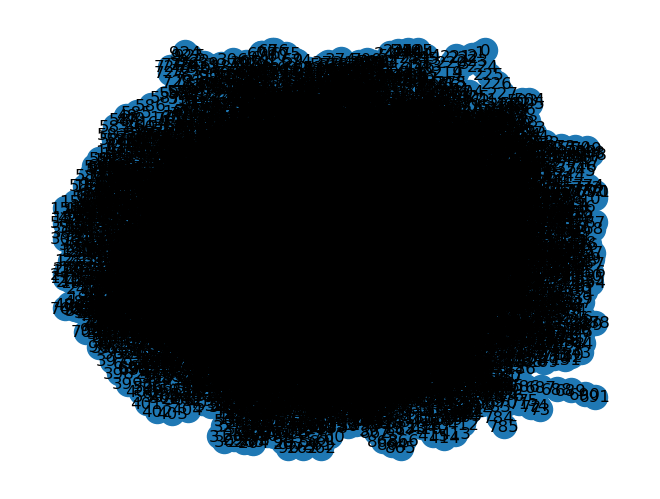

In [69]:
for epoch in range(num_epochs):
    print("epoch", epoch)
    for batch in custom_graph_data_loader(graphs, batch_size):
        # Generate fake data
        random_noise_graphs_batch = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)

        # Ensure the real edge_index is correctly shaped [2, num_edges]
        if batch.edge_index.size(0) != 2:
            batch.edge_index = batch.edge_index.t()  # Transpose if necessary        
        
        # Create fake data batch with both x and edge_index
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)

        # Labels for real and fake data (for each node)
        real_labels = torch.ones(batch.x.size(0), 1)
        fake_labels = torch.zeros(fake_data.x.size(0), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(batch), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # Recompute fake data and perform forward pass through discriminator
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)
        updated_real_labels = torch.ones(fake_data.x.size(0), 1)
        g_loss = adversarial_loss(discriminator(fake_data), updated_real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        
        # Calculate discriminator accuracy
        real_accuracy = calculate_accuracy(discriminator(batch).detach(), real_labels)
        print("real_accuracy",real_accuracy)
        fake_accuracy = calculate_accuracy(discriminator(fake_data).detach(), fake_labels)
        print("fake_accuracy",fake_accuracy)
        d_accuracy = (real_accuracy + fake_accuracy) / 2

        # Store metrics
        d_losses.append(d_loss.item())
        print("d_loss.item()",d_loss.item())
        g_losses.append(g_loss.item())
        print("g_loss.item()",g_loss.item())
        d_accuracies.append(d_accuracy.item())
        real_accuracy_list.append(real_accuracy.item())
        fake_accuracy_list.append(fake_accuracy.item())
        
        # Post-Processing for Visualization and Analysis
        if epoch % snapshot_interval == 0:
            # Visualize the graph
            visualize_fake_graph(fake_x, fake_edge_index, epoch)

            # Update frequency counts
            update_frequency_counts(fake_edge_index, edge_frequency, node_frequency)
            print("edge_frequency, node_frequency",edge_frequency, node_frequency)
                
        epochs.append(epoch)


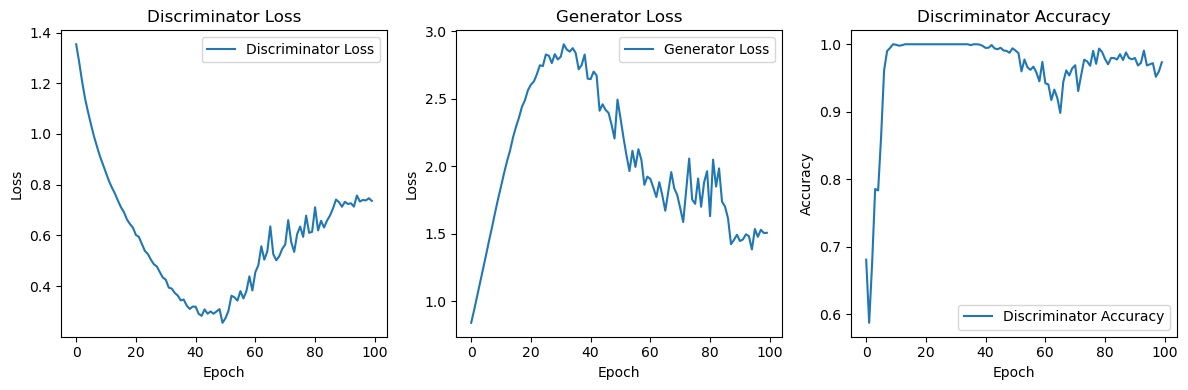

In [70]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
# Platting the values again

In [72]:
# Now we can calculate the averages and plot the values as previously done
# Calculate average values per epoch
avg_real_accuracies = []
avg_fake_accuracies = []
avg_d_losses = []
avg_g_losses = []

In [73]:
# Helper function for averaging
def calculate_average(values):
    return np.mean(values) if values else 0

current_epoch = 0
temp_real_acc = []
temp_fake_acc = []
temp_d_loss = []
temp_g_loss = []

In [74]:
for i in range(len(epochs)):
    if epochs[i] != current_epoch:
        # Calculate averages for the current epoch and reset lists
        avg_real_accuracies.append(calculate_average(temp_real_acc))
        avg_fake_accuracies.append(calculate_average(temp_fake_acc))
        avg_d_losses.append(calculate_average(temp_d_loss))
        avg_g_losses.append(calculate_average(temp_g_loss))

        temp_real_acc = []
        temp_fake_acc = []
        temp_d_loss = []
        temp_g_loss = []
        current_epoch = epochs[i]

    # Append current values
    temp_real_acc.append(real_accuracy_list[i])
    temp_fake_acc.append(fake_accuracy_list[i])
    temp_d_loss.append(d_losses[i])
    temp_g_loss.append(g_losses[i])

In [75]:
# Add averages for the last epoch
avg_real_accuracies.append(calculate_average(temp_real_acc))
avg_fake_accuracies.append(calculate_average(temp_fake_acc))
avg_d_losses.append(calculate_average(temp_d_loss))
avg_g_losses.append(calculate_average(temp_g_loss))

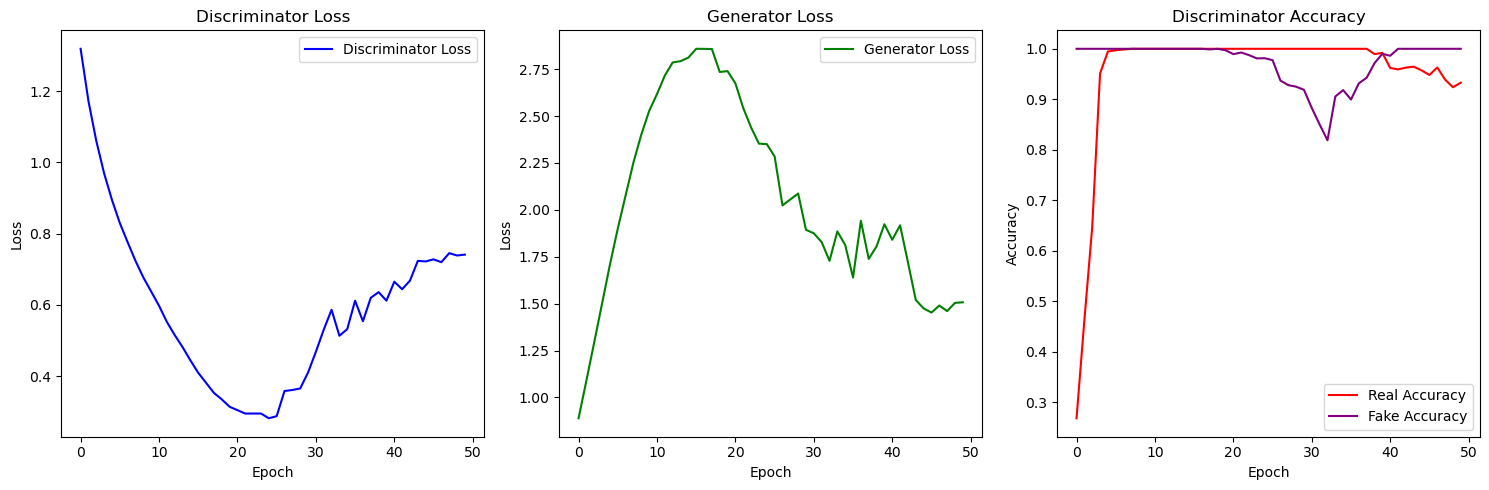

In [76]:
# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Plotting the graphs
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, avg_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, avg_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, avg_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, avg_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


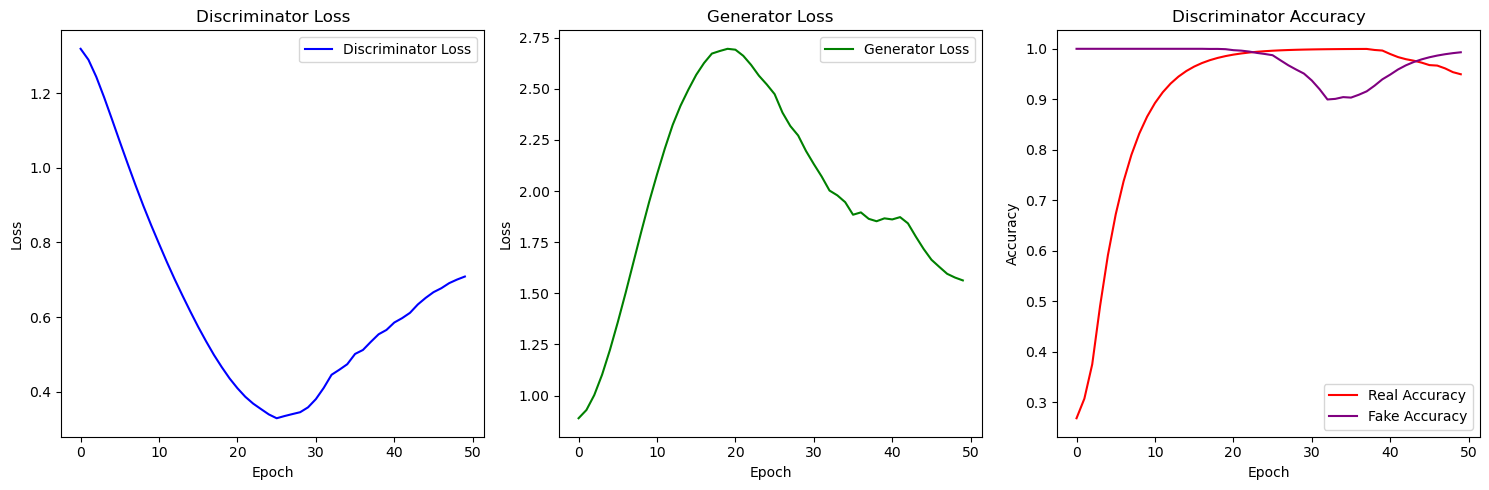

In [77]:
import matplotlib.pyplot as plt
import numpy as np


# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Smoothing the lines
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Applying smoothing
smoothed_d_losses = smooth_curve(avg_d_losses)
smoothed_g_losses = smooth_curve(avg_g_losses)
smoothed_real_accuracies = smooth_curve(avg_real_accuracies)
smoothed_fake_accuracies = smooth_curve(avg_fake_accuracies)

# Plotting the graphs with enhanced visualization
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, smoothed_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, smoothed_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, smoothed_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, smoothed_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


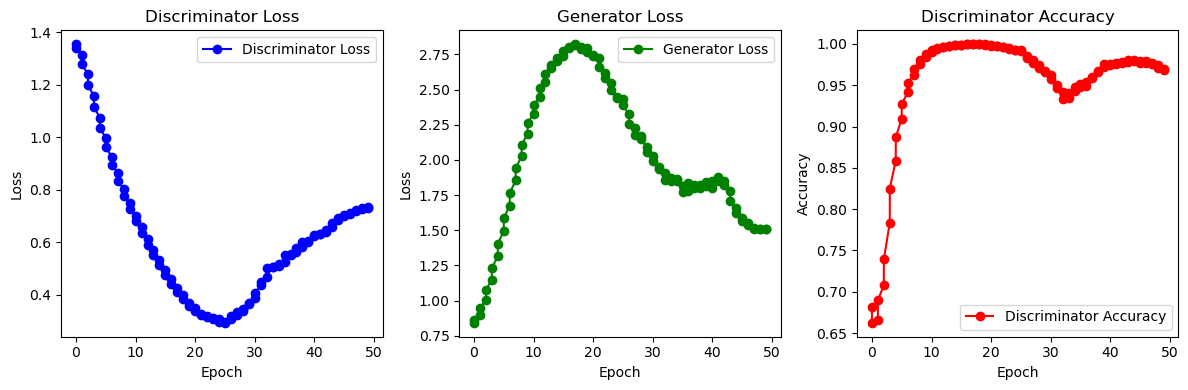

In [78]:
# Applying smoothing to these data as well
smoothed_d_losses1 = smooth_curve(d_losses)
smoothed_g_losses1 = smooth_curve(g_losses)
smoothed_d_accuracies1 = smooth_curve(d_accuracies)

# Enhanced plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, smoothed_d_losses1, label='Discriminator Loss', color='blue', marker='o')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, smoothed_g_losses1, label='Generator Loss', color='green', marker='o')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, smoothed_d_accuracies1, label='Discriminator Accuracy', color='red', marker='o')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


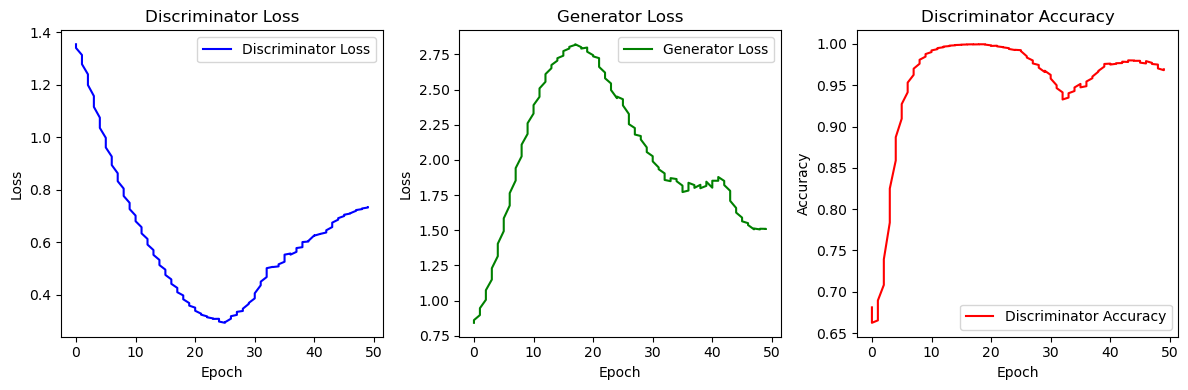

In [79]:
# Applying smoothing to these data as well
smoothed_d_losses1 = smooth_curve(d_losses)
smoothed_g_losses1 = smooth_curve(g_losses)
smoothed_d_accuracies1 = smooth_curve(d_accuracies)

# Enhanced plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, smoothed_d_losses1, label='Discriminator Loss', color='blue')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, smoothed_g_losses1, label='Generator Loss', color='green')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, smoothed_d_accuracies1, label='Discriminator Accuracy', color='red')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


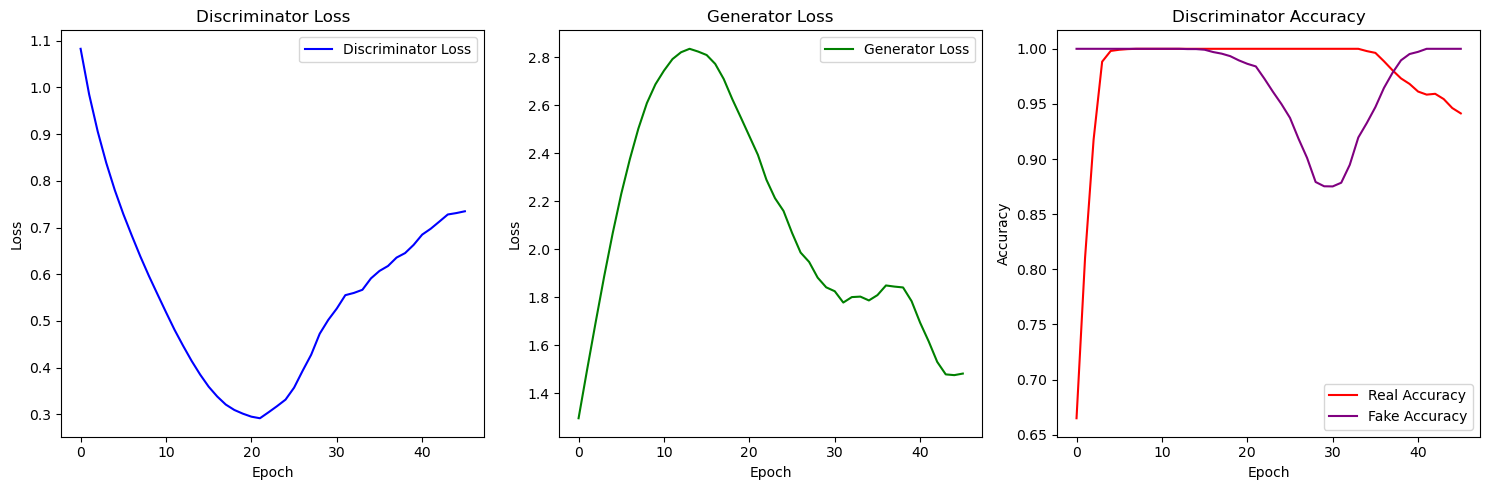

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))
window_size = 5

# Smoothing the lines with Simple Moving Average
def smooth_curve_SMA(points, window_size=5):
    window = np.ones(window_size) / window_size
    return np.convolve(points, window, 'valid')

# Applying SMA smoothing
smoothed_d_losses = smooth_curve_SMA(avg_d_losses)
smoothed_g_losses = smooth_curve_SMA(avg_g_losses)
smoothed_real_accuracies = smooth_curve_SMA(avg_real_accuracies)
smoothed_fake_accuracies = smooth_curve_SMA(avg_fake_accuracies)

# Adjusting 'unique_epochs' for the reduced size after convolution
adjusted_epochs = unique_epochs[:len(unique_epochs) - window_size + 1]

# Plotting the graphs with enhanced visualization
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(adjusted_epochs, smoothed_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(adjusted_epochs, smoothed_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(adjusted_epochs, smoothed_real_accuracies, label='Real Accuracy', color='red')
plt.plot(adjusted_epochs, smoothed_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [81]:
# Fake graph generation visuals